# Analysis of Campervan characteristics

...

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from common import SqliteOperator, get_pie_chart, get_hist_chart

In [3]:
plt.rcParams['figure.figsize'] = (12, 8)

# Getting data

Scrapping the data from the [GoBoony](https://www.goboony.com/) and [MarktPlaats](https://www.marktplaats.nl/) websites was done beforehand.
The scrapping was done with selenium and saved in a SQLite database.

After scrapping the we attempted to compute the income from the number of days a camper was unavailable multiplied by its price.
Subsequently the price of a similar camper found for sale on MarktPlaats was deducted from this income to get a somewhat realistic income.
This assumes two things:
- If the camper is unavailable it's rented at the price stated at the moment when the was scrapped.
- The price of camper of the same brand with similar build is consistent.

In [4]:
sql = SqliteOperator('data/sql.db')
df = sql.get_table('GoboonyAds')
df.drop(['camper_id', 'title', 'url', 'available'], axis=1, inplace=True)
df.head()

,price,category,unavailable,brand,fuel_type,transmission,nr_seats,nr_beds,build_year,deposit,free_klicks,cost_extra_klicks,rented,income
0,61.0,Classic,59,Volkswagen,Benzine,Handgeschakeld,6,2,1980.0,1000.0,1750,0.2,44.25,829.25
1,115.0,Familie,129,Bürstner,Diesel,Handgeschakeld,4,4,2017.0,1000.0,1500,0.2,96.75,9256.25
2,105.0,Classic,419,Rimor,Diesel,Automaat,7,7,2018.0,1000.0,2000,0.3,314.25,31126.25
3,75.0,Compact,114,Volkswagen,Diesel,Handgeschakeld,4,4,1992.0,1000.0,1500,0.2,85.50,4542.50
4,110.0,Classic,105,Pössl,Diesel,Handgeschakeld,4,2,2014.0,1000.0,1500,0.2,78.75,6792.50


# Analysis

Analysing the bare minimum already tells us something about our data. For example some camper don't seem to make the owner money, since the income is negative.

In [5]:
df.describe()

,price,unavailable,nr_seats,nr_beds,build_year,deposit,cost_extra_klicks,rented,income
count,865.000000,865.000000,865.000000,865.000000,862.000000,865.000000,761.000000,865.000000,865.000000
mean,102.035838,114.099422,4.335260,3.579191,2007.800464,1040.057803,0.219356,85.574566,6856.429480
std,27.876752,82.406790,1.196433,1.338024,11.283573,166.959802,0.047895,61.805092,6871.218129
min,24.000000,0.000000,2.000000,2.000000,1968.000000,500.000000,0.100000,0.000000,-1870.000000
25%,85.000000,68.000000,4.000000,2.000000,2002.000000,1000.000000,0.200000,51.000000,2713.250000
50%,99.000000,94.000000,4.000000,4.000000,2010.000000,1000.000000,0.200000,70.500000,5078.750000
75%,119.000000,130.000000,5.000000,4.000000,2017.000000,1000.000000,0.250000,97.500000,8893.250000
max,412.000000,572.000000,8.000000,8.000000,2022.000000,2000.000000,0.600000,429.000000,58205.000000


Actually 33 of the 865 campers available in the data are nonprofitable. It would be interesting to find out why.

In [6]:
(df['income']<=0).sum(), df['income'].count()

(np.int64(33), np.int64(865))

## Visualization

When taking one step deeper we other interesting trends.

For example diesel campers seem to be trending among camper owners. It would be interesting to find out if the market of camper renters aligns with this. Or if they want more environmental friendly alternatives.

These figures also show that we have a skewed dataset, this might impact further analysis.

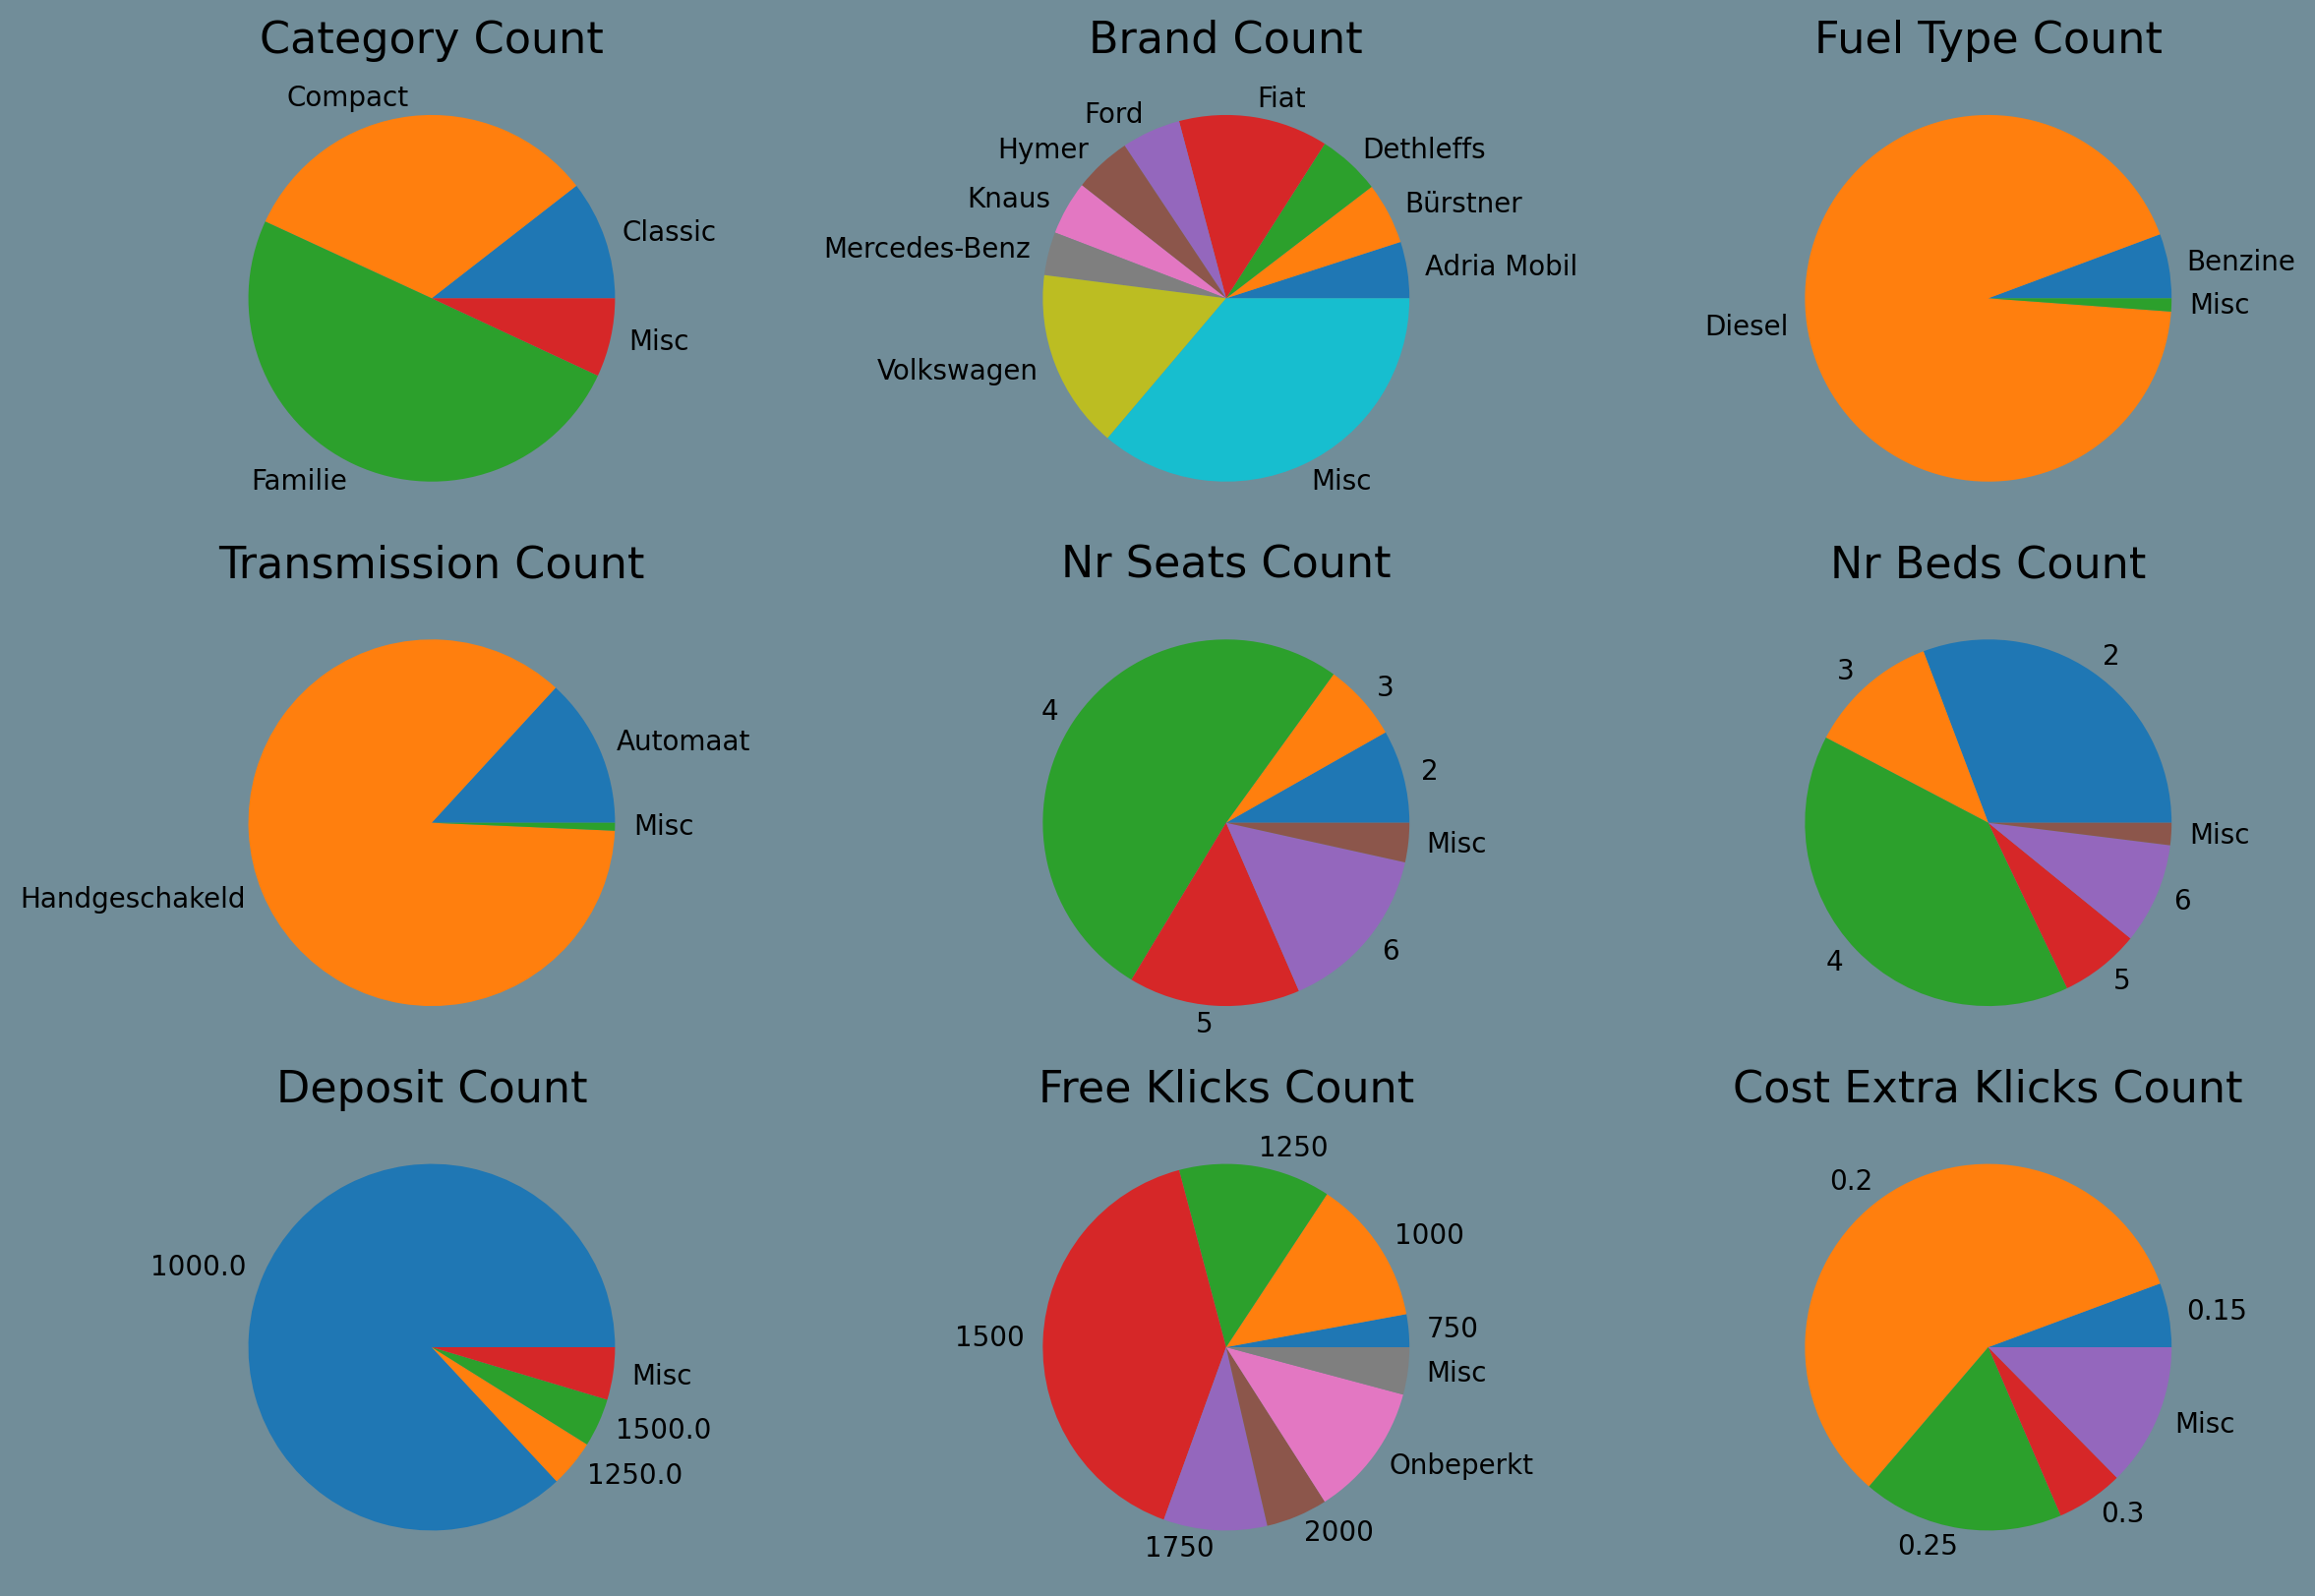

In [7]:
fig, (
    (ax11, ax12, ax13),
    (ax21, ax22, ax23),
    (ax31, ax32, ax33),
) = plt.subplots(3, 3)

get_pie_chart(ax11, df, 'category')
get_pie_chart(ax12, df, 'brand')
get_pie_chart(ax13, df, 'fuel_type')

get_pie_chart(ax21, df, 'transmission')
get_pie_chart(ax22, df, 'nr_seats')
get_pie_chart(ax23, df, 'nr_beds')

get_pie_chart(ax31, df, 'deposit')
get_pie_chart(ax32, df, 'free_klicks')
get_pie_chart(ax33, df, 'cost_extra_klicks')

When we look at the continious features we see that the day price is centered around 100 euro. And also that the old camper is dying out.

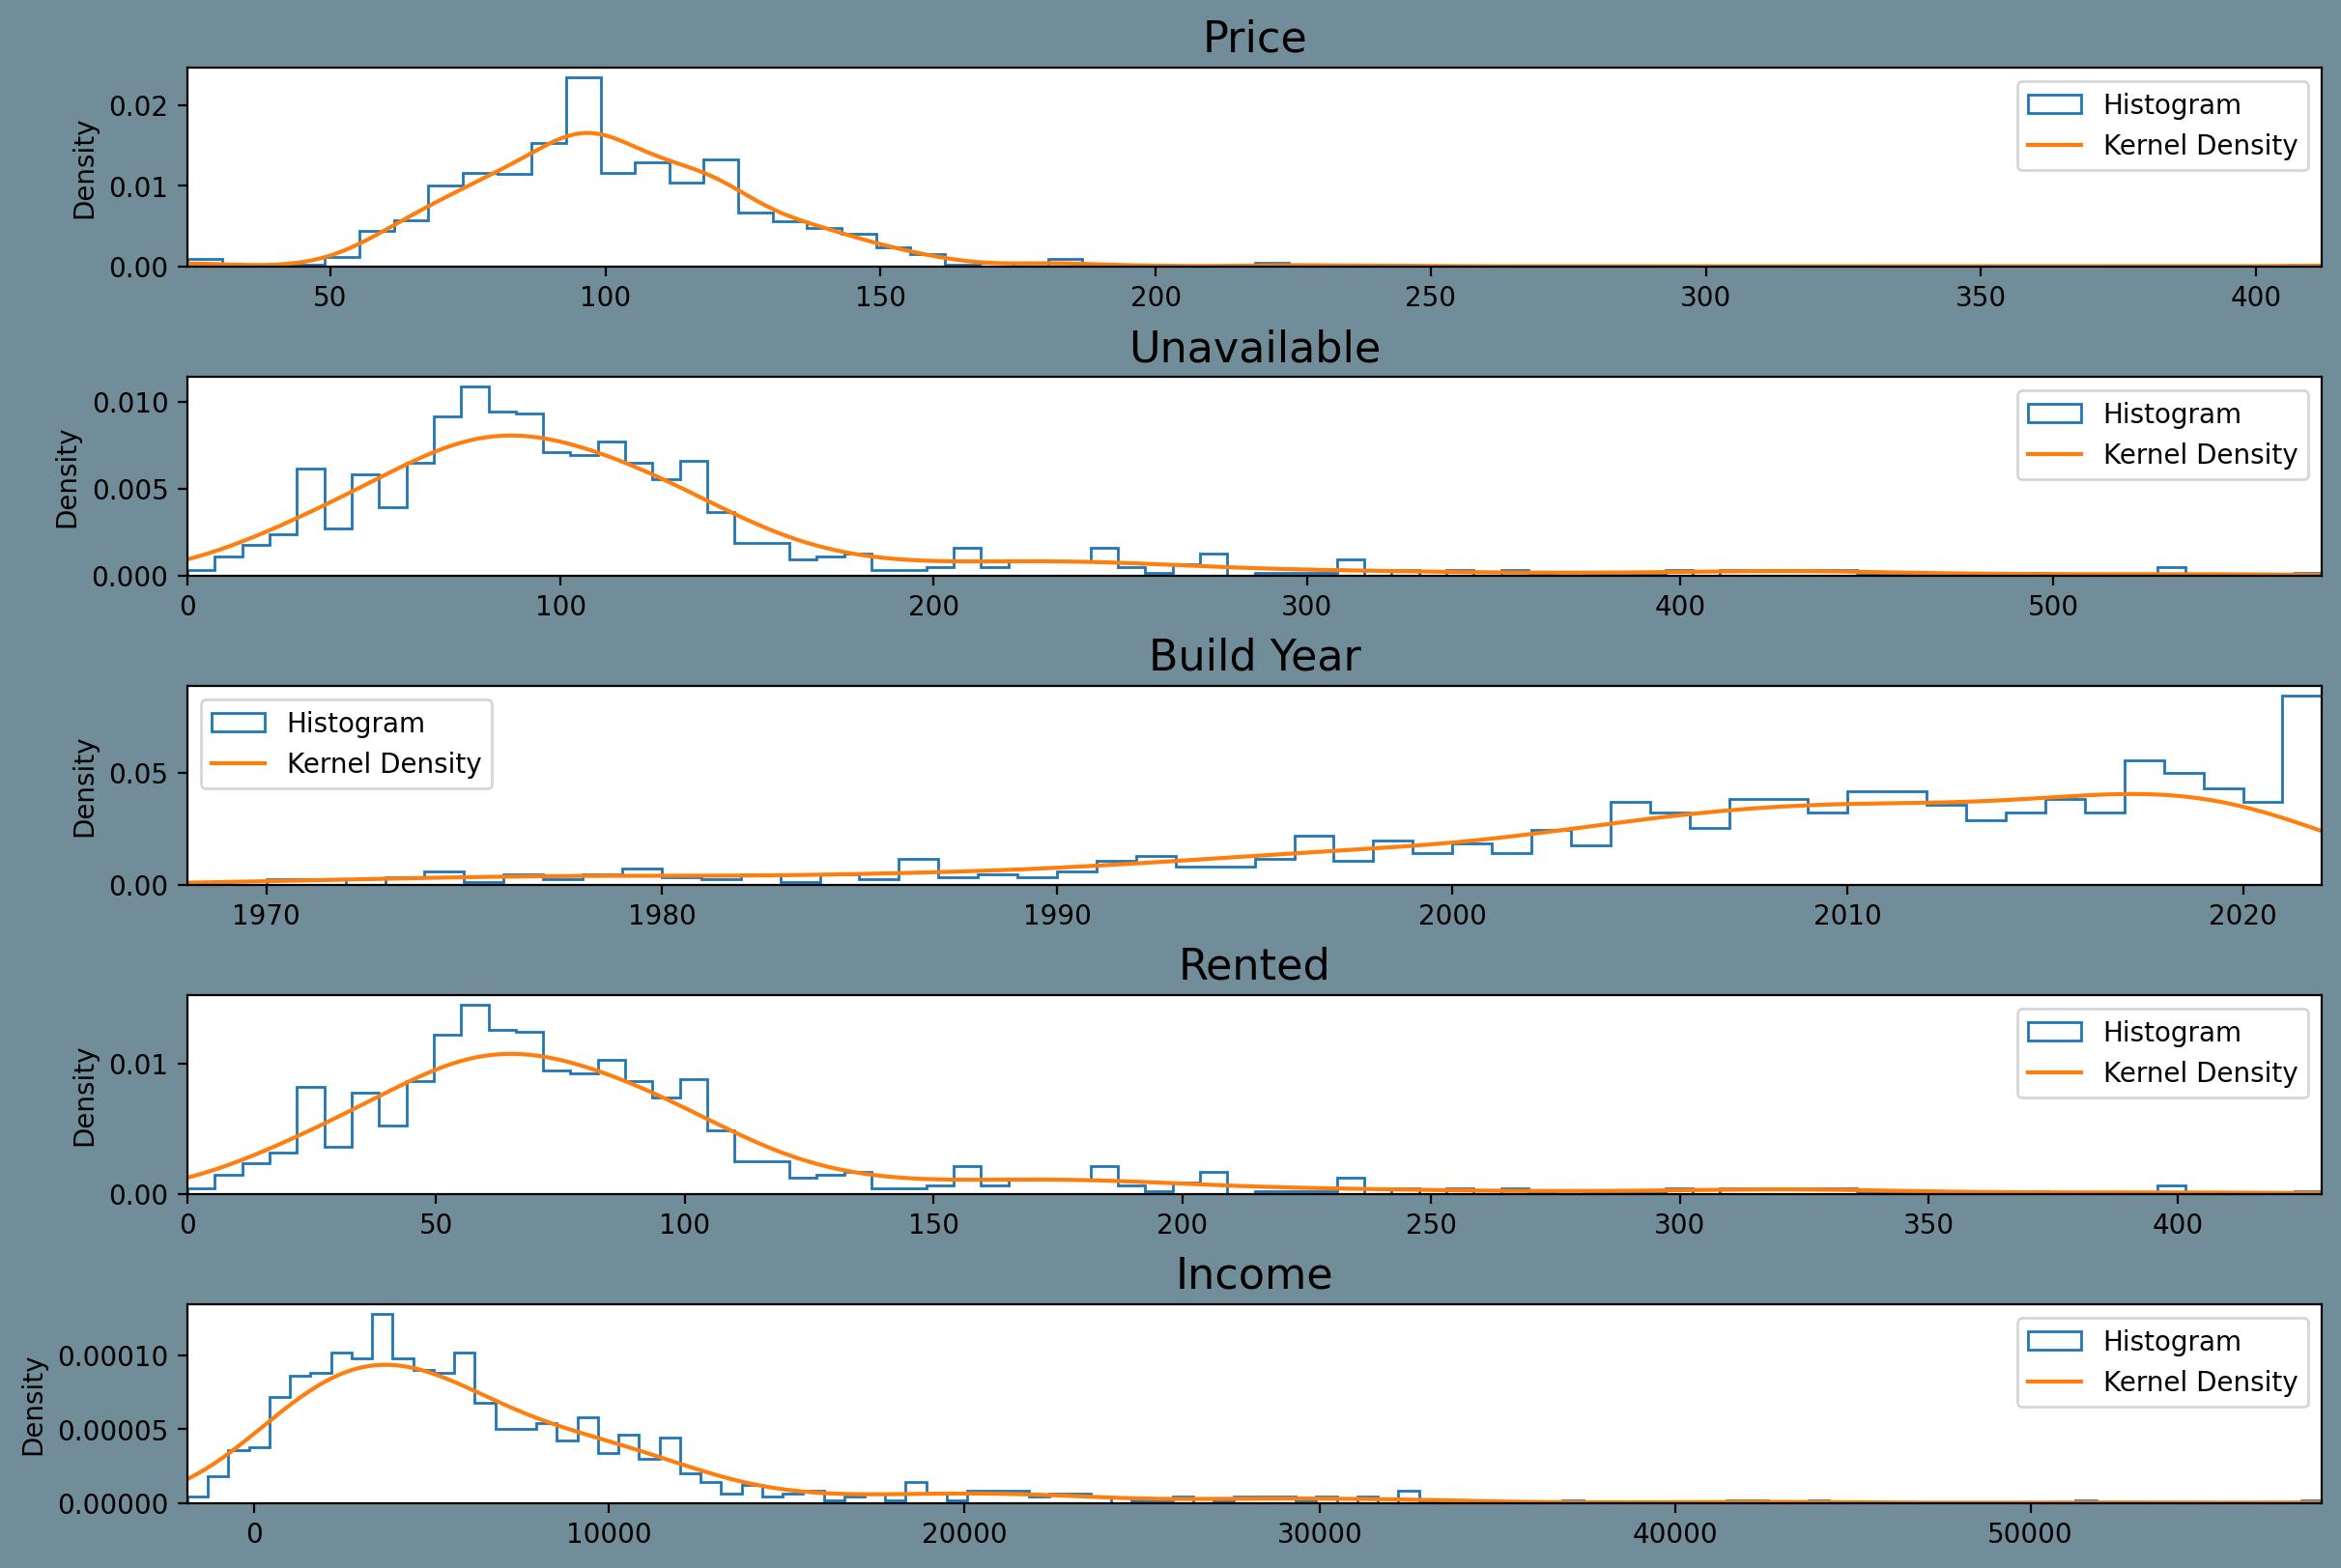

In [8]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)

get_hist_chart(ax1, df, 'price')
get_hist_chart(ax2, df, 'unavailable')
get_hist_chart(ax3, df, 'build_year')
get_hist_chart(ax4, df, 'rented')
get_hist_chart(ax5, df, 'income')

## Correlation

Next lets see if there's any significant correlation between either features.
First we map the data to numeric data and try ordinary least squares (OLS) to find significant correlations.

We remove the features that are interdependent. Nonetheless, no features seem to have p-value (`P>|t|`) higher than 0.9, meaning no interesting linear correlations.

In [9]:
udf = df.copy()
for c in ['brand', 'category', 'free_klicks', 'fuel_type', 'transmission']:
    mapper = {k: v for v, k in enumerate(set(df[c]))}
    udf[c] = df[c].map(mapper)
    
udf.pop('rented')
udf.pop('unavailable')
udf.pop('price')
udf.head()

,category,brand,fuel_type,transmission,nr_seats,nr_beds,build_year,deposit,free_klicks,cost_extra_klicks,income
0,3,76,4,2,6,2,1980.0,1000.0,8,0.2,829.25
1,2,11,3,2,4,4,2017.0,1000.0,9,0.2,9256.25
2,3,0,3,0,7,7,2018.0,1000.0,6,0.3,31126.25
3,1,76,3,2,4,4,1992.0,1000.0,9,0.2,4542.50
4,3,40,3,2,4,2,2014.0,1000.0,9,0.2,6792.50


In [10]:
import statsmodels.api as sm

x = udf.copy().dropna()
y = x.pop('income')
x = sm.add_constant(x)
model = sm.OLS(y, x)
r = model.fit()
r.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.098
Method:                 Least Squares   F-statistic:                     9.226
Date:                Wed, 07 Aug 2024   Prob (F-statistic):           1.71e-14
Time:                        18:24:17   Log-Likelihood:                -7753.5
No. Observations:                 758   AIC:                         1.553e+04
Df Residuals:                     747   BIC:                         1.558e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -3.656e+05   5.54e+04     -6.596      0.000   -4.74e+05   -2.57e+05
category           1097.1417    389.698      2.815      0.005     332.108    1862.176
brand               -23.0730      9.119     -2.530      0.012     -40.975      -5.171
fuel_type           947.4496    902.389      1.050      0.294    -824.070    2718.969
transmission       -550.7513    374.659     -1.470      0.142   -1286.261     184.758
nr_seats            778.4064    275.365      2.827      0.005     237.824    1318.988
nr_beds            -710.0574    254.887     -2.786      0.005   -1210.438    -209.677
build_year          183.9008     27.192      6.763      0.000     130.520     237.282
deposit              -0.7000      1.451     -0.482      0.630      -3.549       2.149
free_klicks         -70.5820     69.455     -1.016      0.310    -206.933      65.769
cost_extra_klicks  3662.5136   5328.318      0.687      0.492   -6797.745    1.41e+04
==============================================================================
Omnibus:                      436.411   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3770.070
Skew:                           2.503   Prob(JB):                         0.00
Kurtosis:                      12.711   Cond. No.                     5.12e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.12e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""